In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import torch
from torch.nn import functional as F

from config import *

from src.datafeed.downstream import get_fx_data
from src.visualization.utilities import plot_convolution_filter
from src.finance import get_long_short_legs

In [2]:
# helper to print dataframes nicely
def style_time_series(df, n_tail=6, mult=1.0, precision=2, **kwargs):
    _res = df.tail(n_tail).mul(mult).rename_axis(index="date")
    _res = _res.style\
        .set_properties(**{'width': '50px'})\
        .format(precision=precision, **kwargs)\
        .format_index(lambda _x: _x.strftime("%Y-%m-%d"))
    return _res

In [3]:
# load data
data = get_fx_data()

For each currency, I calculate 1-month excess returns $rx$ in a forward-looking manner, that is, $rx_t = \frac{S_{t+1m}}{F_t}$. Note that the returns are observed daily, which increases the number of data points twenty-fold compared to the case when monthly returns are observed monthly.

In [4]:
rx = data["excess_returns"]

print("1-month forward-looking excess returns, in %")
display(style_time_series(rx.loc[:"2023-05-01"], n_tail=3, mult=100))

1-month forward-looking excess returns, in %


currency,aud,cad,chf,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,
2023-04-27,-1.03,0.07,-1.96,-3.07,-0.43,-3.92,-3.71,-1.24,-4.58
2023-04-28,-0.21,0.71,-1.66,-2.96,-1.10,-3.04,-3.61,-1.85,-5.71
2023-05-01,-0.34,0.82,-1.56,-2.58,-0.54,-1.48,-2.84,-1.44,-5.21


For each currency, define the date-$t$ term structure history (TSH) as the $T \times M$ matrix containing the history of forward prices for $M$ tenors over the past $T$ periods. In our case $M=8$ tenors: from spot to 2 years. Let the lookback $T$ be 6 days (including today) to simplify visualizations.

In [5]:
# display term struct history
tsh = data["term_structure_history"]

lookback = 6  # incl today

tenors = list(tsh.columns.get_level_values("maturity").categories)
n_tenors = len(tenors)

print(tenors)

['spot', '1m', '2m', '3m', '6m', '9m', '12m', '2y']


In [6]:
print(f"{lookback}-day term structure history of aud on 2023-05-01")
display(
    style_time_series(
        tsh.loc[:"2023-05-01", ["aud"]].tail(lookback), 
        precision=4
    ).background_gradient(cmap='Reds')
)

6-day term structure history of aud on 2023-05-01


Let's also define the normalized term structure history NTSH as follows: divide all values by the date-$t$ spot price, take the log and 'annualize' all values except the spot column:

In [7]:
annualizer = pd.Series({"spot": 1,
                        "1m"  : 12/1,
                        "2m"  : 12/2,
                        "3m"  : 12/3,
                        "6m"  : 12/6,
                        "9m"  : 12/9,
                        "12m" : 12/12,
                        "2y"  : 12/24})

def normalize_term_structure(ts):
    _res = ts\
        .div(ts.iloc[-1].xs("spot", level="maturity"), axis=1, level="currency")\
        .pipe(np.log)\
        .mul(annualizer, axis=1, level="maturity")
    return _res

In [8]:
print(f"normalized {lookback}-day term structure history of aud on 2023-05-01")
display(
    style_time_series(
        normalize_term_structure(
            data["term_structure_history"].loc[:"2023-05-01", ["aud"]].tail(lookback)
        ), 
        precision=4
    ).background_gradient(cmap='Reds')
)

normalized 6-day term structure history of aud on 2023-05-01


This normalized matrix encodes many signals commonly used to construct FX strategies. For instance, a carry trade signal can be extracted by simply observing the most recent value in column '1m', the 5-day momentum signal &ndash; by observing the value in column 'spot' five days from today, a skewness signal &ndash; by subtracting the most recent value in column '12m' from that in column '1m', and so on. In fact, any signal that is a linear transformation of the NTSH can be extracted with a suitable convolution.

Remembering that the tenors are `['spot', '1m', ...]`, the following convolution extracts the 1-month carry signal from a TSH of a currency.

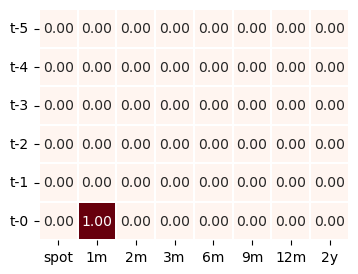

In [9]:
# convolution for carry signal
conv_carry = np.zeros(shape=(lookback, n_tenors), dtype=float)
conv_carry[-1, 1] = 1

plot_convolution_filter(conv_carry, xticklabels=tenors)

And, not surprizingly, convolving it with the NTSH gives the carry of AUD on 2023-05-01. We use `pytorch.nn.functional.conv2d` for this and have to expand some dimensions along the way.

In [10]:
# get NTSH for AUD on 2023-05-01
one_ntsh = normalize_term_structure(
    data["term_structure_history"].loc[:"2020-12-01", ["aud"]].tail(6)
)

# get that carry! (converting to tensors and expanding dims to conform w/pytorch)
sig_carry = F.conv2d(
    torch.from_numpy(one_ntsh.values)[None, None, ...], 
    torch.from_numpy(conv_carry)[None, None, ...]
).squeeze().numpy()

print("NTSH:")
display(style_time_series(one_ntsh, precision=4))

print("\nextracting the 1-month carry signal: {:.4f}".format(sig_carry))

NTSH:



extracting the 1-month carry signal: 0.0046


Applying it to the whole cross-section of currencies is simply achieved by setting the stride parameter to equal the number of tensors.

In [11]:
many_ntsh = normalize_term_structure(
    data["term_structure_history"].loc[:"2020-12-01"].tail(6)
)

print("extracting the 1-month carry signal:")
print(
    F.conv2d(
        torch.from_numpy(many_ntsh.values)[None, None, ...], 
        torch.from_numpy(conv_carry)[None, None, ...],
        stride=(1, n_tenors)
    ).squeeze().numpy().round(4)
)

print("\n")
print("the actual 1-month forward discounts:")
display(style_time_series(many_ntsh.xs("1m", axis=1, level="maturity").tail(1),
                          precision=4))



extracting the 1-month carry signal:
[0.0046 0.0032 0.0165 0.0135 0.0073 0.0101 0.0031 0.0011 0.011 ]


the actual 1-month forward discounts:


currency,aud,cad,chf,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,
2020-12-01,0.0046,0.0032,0.0165,0.0135,0.0073,0.0101,0.0031,0.0011,0.0110


These can be used with the softmax activation function to get the weights in a long-short portfolio. To do so, I normalize the signals by subtracting the mean and dividing by the standard deviation, and take the modified softmax, forcing the values to be approximately between -1 and 1 and sum to zero.

In [12]:
# calculate signals
signals = F.conv2d(
    torch.from_numpy(many_ntsh.values)[None, None, ...], 
    torch.from_numpy(conv_carry)[None, None, ...],
    stride=(1, n_tenors)
).squeeze()

n_assets = len(signals)

# normalize, take softmax with temperature parameter = 1.5
_w = (
    F.softmax((signals - torch.mean(signals)) / torch.std(signals) * 1.5, dim=0) \
        - 1/n_assets
) * 2
w = pd.DataFrame(_w[None, ...], index=many_ntsh.index[[-1]], 
                 columns=many_ntsh.columns.unique("currency"))

print("long-short portfolio weights:")
style_time_series(w, precision=4)

long-short portfolio weights:


currency,aud,cad,chf,eur,gbp,jpy,nok,nzd,sek
date,,,,,,,,,
2020-12-01,-0.1874,-0.1988,0.7998,0.2142,-0.1484,-0.0573,-0.2000,-0.2095,-0.0126


These weights are different from the ones frequently used in long-short rank-based strategies, but, hopefully, close enough. The carry trade strategy constructed with such weights is profitable, as shown below:

In [13]:
# normalize and take softmax with a temperature parameter
def normalized_softmax(_x, dim=-1, temp=1.5):
    _res = (
        F.softmax(
            (_x - torch.mean(_x, dim=dim, keepdim=True)) / \
                torch.std(_x, dim=dim, keepdim=True) * \
                temp, 
            dim=dim
        ) - 1/n_assets
    ) * 2
    return _res

In [14]:
_fd = data["fd_annualized"].xs("1m", axis=1, level="maturity")
fd = torch.from_numpy(_fd.values)

signals_carry_conv = pd.DataFrame(
    normalized_softmax(fd).numpy(), 
    index=_fd.index, 
    columns=_fd.columns
)

signals_carry_standard = get_long_short_legs(_fd, 3)

carry_conv_rx = rx.mul(signals_carry_conv).sum(axis=1, min_count=1)
carry_standard_rx = rx.mul(signals_carry_standard).sum(axis=1, min_count=1)

print(
    "avg return of the modified carry trade strategy, annualized: {:.2f}"\
        .format(carry_conv_rx.mean() * 1200)
)
print(
    "avg return of the 'standard' carry trade strategy, annualized: {:.2f}"\
        .format(carry_standard_rx.mean() * 1200)
)
print(
    "correlation between the two strategies: {:.2f}"\
        .format(carry_conv_rx.corr(carry_standard_rx)
))

avg return of the modified carry trade strategy, annualized: 4.01
avg return of the 'standard' carry trade strategy, annualized: 3.40
correlation between the two strategies: 0.83


I hope that the convolution that gives some 'optimal' long-short portfolio weights can be learned from the data... For this, I would first need to define 'optimal'.